# Inhoud

1. Alles-alles correlaties, onhandige plot. (zou handig zijn als automatisch gesplitst in meerdere svgs..

2. Correlaties, [gefocussed op](#Uitwerken-vanuit-bepaalde-stoffen) `ZS` en aantal gerelateerde stoffen.

3. **TODO** Nadat opgemerkt selectie op locatie wellicht belangrijk, zelfde analyse rond locatie?

4. [Distributie correlaties](#Histogram-van-correlaties).

5. [Per groep gecorreleerde stoffen](#De-groepen-los)

6. [Per-locatie](#Per-locatie)

In [1]:
from src.CovAll import CovAll

In [2]:
import pandas as pd

par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']

# TODO restrict columns.
df = pd.read_csv("../data/intermediate/rest.csv", parse_dates=['DATUM:TIJD'],
                       usecols=par_par + point_par + ['CPM'])

In [3]:
import pandas as pd

# read data
path = '../data/data_tot.csv'

par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']

columns = par_par + point_par[:-1] + ['DATUM', 'TIJD', 'CPM']

omschrijvingen = ['ID', 'LOCOMS', 'ORGOMS', 'BTXCOD', 'BTXOMS',
                  'GBDOMS', 'OGIOMS', 'ANIOMS', 'BHIOMS',
                  'BMIOMS', 'VATOMS']

df = pd.read_csv(path, encoding='latin1', usecols=columns, engine='c')

def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.apply(lambda v: dates[v])

df.insert(0, 'DATUM:TIJD', lookup(df.DATUM + df.TIJD))
df.drop(['DATUM', 'TIJD'], axis=1, inplace=True)

In [4]:
covall = CovAll(df, groupby=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], k_xs=['PAR', 'EHD'], k_y= 'WAARDE')

Figuring parameter indices..
Calculating correlations.. (between 661 params)
10
100
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [5]:
import pandas as pd
oms_df = pd.read_csv("../data/intermediate/oms.csv")
oms_df.drop('index', axis=1, inplace=True)

def oms_par(name):
    return next(iter(oms_df[(oms_df.type=='PAROMS') & (oms_df.name==name)].desc))

import graphviz, math

def graphviz_list(into, lst):  # TODO nodes need to be instanciated?
    node_fmt = "{}({},{})"
    for (par1,u1), (par2,u2), c,cs in lst:
        into.edge(node_fmt.format(oms_par(par1), par1,u1), node_fmt.format(oms_par(par2), par2,u2),
                  label="{0:.2f}({1})".format(c,cs[0]))
    return into

import numpy as np

def combine_interests(df, interests, val='WAARDE', loc=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], de_unit=True):
    gen = ([l, [cdf[(cdf.PAR==par) & (cdf.EHD==ehd)][val] for par,ehd in interests]]
            for l,cdf in df.groupby(loc))
    return pd.DataFrame([[*list(l), *[(next(iter(v)) if len(v)>0 else np.nan) for v in vs]]for l,vs in gen],
                        columns = loc + (interests if not de_unit else [n for n,u in interests]))

import seaborn as sns

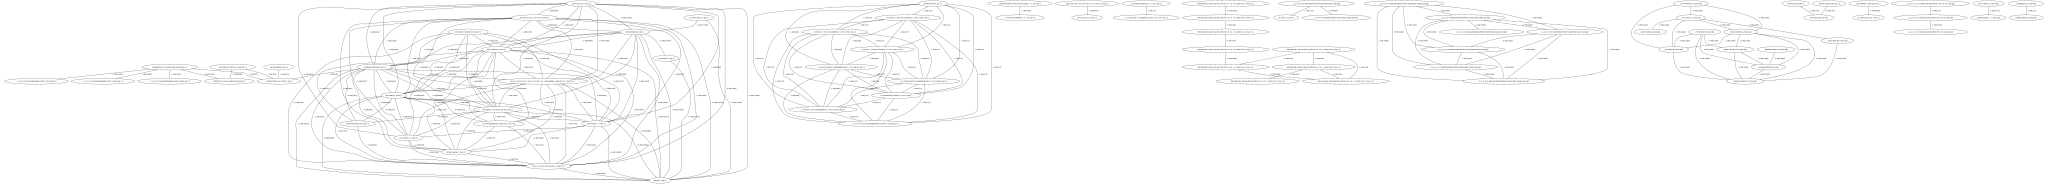

In [6]:
g = graphviz_list(graphviz.Graph(), covall.corr_list()[:200])
#g.render("all_corr_all")
g

# Uitwerken vanuit bepaalde stoffen
* TODO.. waarom zitten delen los.. dat zou niet mogenlijk moeten zijn.

### ZS

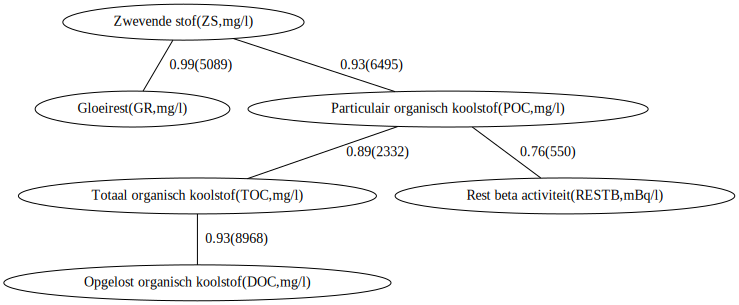

In [7]:
g = graphviz_list(graphviz.Graph(), covall.corr_list_outward({('ZS', 'mg/l')},
                                                              max_depth=5, min_cor=0.7, min_cnt=300))
with open('RWS_corr_ZS.png', 'wb') as fd:
    fd.write(g.pipe('png'))

g

In [8]:
pdf = combine_interests(df, [('ZS', 'mg/l'), ('GR','mg/l'), ('RESTB', 'mBq/l'), ('POC','mg/l'),
                             ('TOC','mg/l'), ('DOC','mg/l')])

In [9]:
import matplotlib.pyplot as plt

g = sns.PairGrid(pdf.drop(['LOC', 'PLT:X', 'PLT:Y','DATUM:TIJD'], axis=1))

def no_whine_hist(*l, **kv):
    try:
        return plt.hist(*l, **kv)
    except:
        return

def log_scatter(x,y, *l, **kv):
    return plt.scatter(np.log10(x), np.log10(y), *l, alpha=0.1, **kv)

g.map_diag(no_whine_hist)
g.map_lower(log_scatter)

/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/jasper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


# NO3
(NO2 heeft zwakkere verbanden)

Veel correlaties gaan wellicht gewoon over de sterke verdunning in de zee? Zee&rarr; verdunt en Zee&rarr; zout &rarr; aantal dingen.

In [10]:
g = graphviz_list(graphviz.Graph(), covall.corr_list_outward({('NO3', 'mg/l')},
                                                              max_depth=2, min_cor=0.8, min_cnt=300))

with open('RWS_all_corr_all.svg', 'wb') as fd:
    fd.write(g.pipe('svg'))

In [11]:
# TODO hardheid vs som nitraat/nitriet.

### NH4

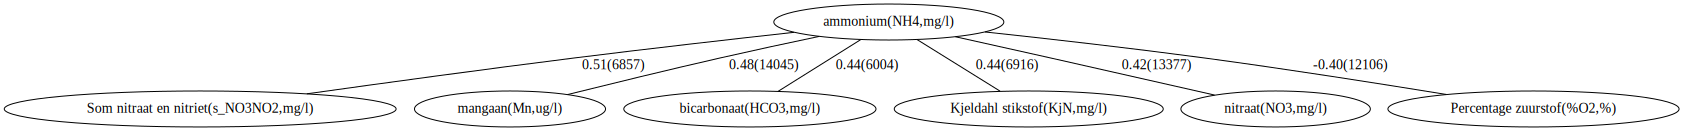

In [12]:
g = graphviz_list(graphviz.Graph(), covall.corr_list_outward({('NH4', 'mg/l')},
                                                              max_depth=1, min_cor=0.4, min_cnt=300))

with open('RWS_corr_nh4.png', 'wb') as fd:
    fd.write(g.pipe('png'))

g

-----

In [13]:
g = graphviz_list(graphviz.Graph(), covall.corr_list_outward({('GELDHD', 'mS/m')},
                                                              max_depth=2, min_cor=0.9, min_cnt=300))
#g

# Selecteer locaties meer

In [14]:
sel_loc_df = pd.read_csv("../data/intermediate/land_loc.csv").drop('Unnamed: 0', axis=1)

sel_loc_set = set(zip(sel_loc_df.LOC, sel_loc_df['PLT:X'], sel_loc_df['PLT:Y']))

sel_df = df[[((loc,x,y) in sel_loc_set) for loc,x,y in zip(df.LOC, df['PLT:X'], df['PLT:Y'])]]
len(sel_df), len(df)

(1346709, 2345295)

In [15]:
covsel = CovAll(sel_df, groupby=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], k_xs=['PAR', 'EHD'], k_y= 'WAARDE')

Figuring parameter indices..
Calculating correlations.. (between 568 params)
10
100
1000
2000
3000
4000
5000
6000
7000
8000


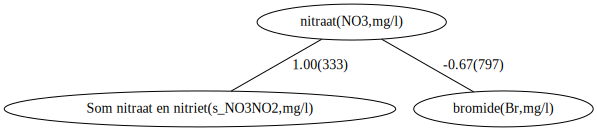

In [16]:
g = graphviz_list(graphviz.Graph(), covsel.corr_list_outward({('NO3', 'mg/l')},
                                                              max_depth=1, min_cor=0.6, min_cnt=300))
g

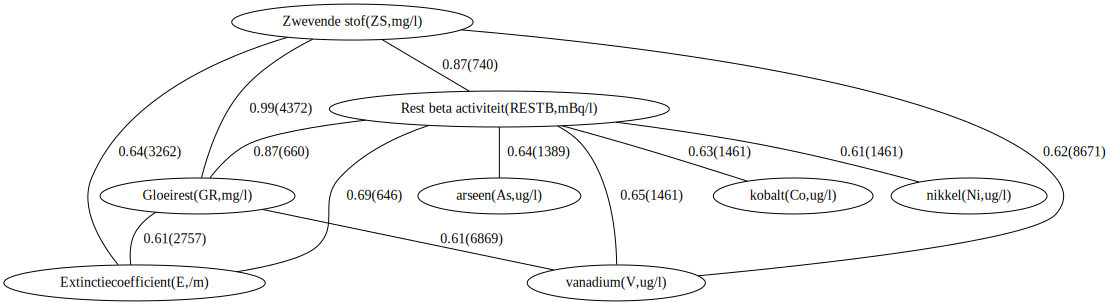

In [17]:
g = graphviz_list(graphviz.Graph(), covsel.corr_list_outward({('ZS', 'mg/l')},
                                                              max_depth=2, min_cor=0.6, min_cnt=300))
g

# Histogram van correlaties
Ondanks de schijn door de explosie van hoeveelheid stoffen as je `max_deph` bover vergroot, zijn meeste dingen
vrij zwak gecorreleert.

Het vergelijkt veel *verschillende* dingen.

In [18]:
corr_df = pd.DataFrame([[*el[0], *el[1], el[2], el[3][0]] for el in covall.corr_list()],
                       columns=['p1','u1', 'p2','u2', 'corr', 'n'])

In [19]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

corr_df[corr_df.n > 400].plot.hist(y='corr', bins=200, logy=True, ax=ax[0],
                                   title="correlations with at least 300 instances")
corr_df[corr_df.n > 400].plot.hist(y='n', bins=200, logy=True, ax=ax[1], title="Number of times pairs are combined.")

### Lage correlaties

In [20]:
def panda_corrlist(corrlist):
    return pd.DataFrame([[*pu1,*pu2, c, cs[0]] for pu1,pu2,c,cs in corrlist],
                        columns = ['par1', 'unit1', 'par2', 'unit2', 'correlation', 'count'])

def corr_df(p, u, max_depth=1, min_cor=0.1, min_cnt=300):
    return panda_corrlist(covall.corr_list_outward([pu], max_depth=max_depth, min_cor=min_cor, min_cnt=min_cnt))

# Not very good..
for pu in [('pH', 'DIMSLS'), ('WINDRTG', 'graad'), ('WINDSHD', 'm/s')]:
    cdf = corr_df(*pu)
    m = cdf.correlation.max()
    got = cdf[cdf.correlation==m]
    print(pu, *[str(next(iter(got[k]))).replace(' ', '\t') for k in got])

('pH', 'DIMSLS') pH DIMSLS GOLFHTE dm 0.2406898749503328 4847
('WINDRTG', 'graad') WINDRTG graad WINDSHD m/s 0.1494019764458806 10775
('WINDSHD', 'm/s') WINDSHD m/s GOLFHTE dm 0.40900033850437967 4825


### WindRichting, snelheid (lage correlaties) 

In [21]:
pd.DataFrame([[*pu1,*pu2, c, cs[0]] for pu1,pu2,c,cs
              in covall.corr_list_outward({('WINDRTG', 'graad')}, max_depth=1, min_cor=0.1, min_cnt=100)],
             columns = ['par1', 'unit1', 'par2', 'unit2', 'correlation', 'count'])
pd.DataFrame([[*pu1,*pu2, c, cs[0]] for pu1,pu2,c,cs
              in covall.corr_list_outward({('WINDSHD', 'm/s')}, max_depth=1, min_cor=0.1, min_cnt=100)],
             columns = ['par1', 'unit1', 'par2', 'unit2', 'correlation', 'count'])
None

### Een plot dan

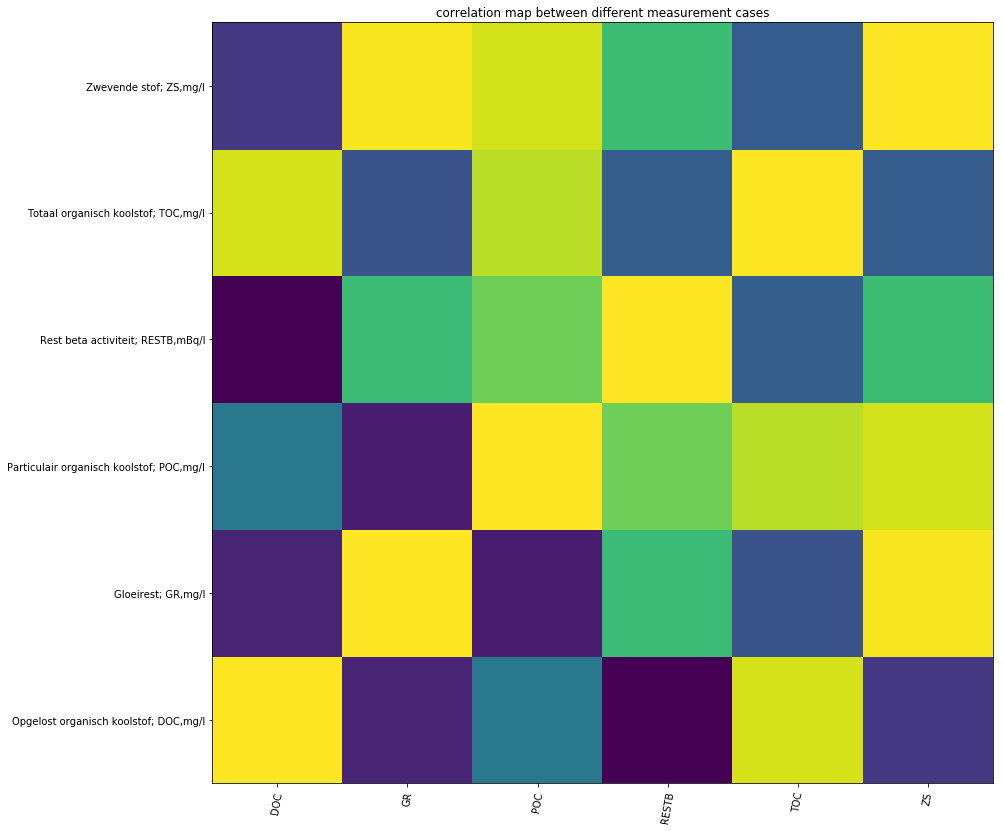

In [22]:
ZS_conn = covall.corr_list_outward({('ZS', 'mg/l')}, max_depth=3, min_cor=0.7)
ZS_conn = list(set(el[0] for el in ZS_conn).union(set(el[1] for el in ZS_conn)))
ZS_conn.sort()
scorr = covall.sub_corr(ZS_conn)

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

fig, ax = plt.subplots(figsize=(14,14))
ax.set_title("correlation map between different measurement cases")
ax.pcolor(np.array(scorr))

xticks = [i+0.5 for i in range(len(ZS_conn))]
ax.set_xticks(xticks)
ax.set_yticks(xticks)
ax.set_xticklabels([p for p,u in ZS_conn], rotation=80)
ax.set_yticklabels(["{}; {},{}".format(oms_par(p), p,u) for p,u in ZS_conn])
None

# Heatmap van alle (te veel) combinaties
`sns.heatmap` beter, maar in dit geval niet veel hoop op iets leesbaars.

Okey, zou al helpen als het een html/javascript output was die relevante namen/beschrijvingen oproept
onhover/onmouseover of/enzo.

In [23]:
len(df.groupby(['PAR', 'EHD']).count()), len(covall.par_i)

(661, 661)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

fig, ax = plt.subplots(figsize=(14,14))
ax.set_title("correlation map between different measurement cases")
ax.pcolor(np.array(covall.correlation()))

In [25]:
def grep_oms(grep, type='PAROMS'):
    return oms_df[[(desc.lower().find(grep)>=0 or name.lower().find(grep)>=0) and tp==type for tp,desc,name in
                   zip(oms_df.type, oms_df.desc, oms_df.name)]]

# De groepen los

In [30]:
groeperingen = ['SO4,mg/l', 'biFy,ug/l', 'ClC2e,ug/l', 's_NO3NO2,mg/l', '2ClC2ol,ug/l', 'PBDE99,ug/kg',
                'PBDE75,ug/kg', '%KGF63,%', 'Yb,mg/kg', 'dieldn,ug/l', 'ZS,mg/l', 'PCB187,ug/kg', 'Ga,mg/kg',
                'Sc,mg/kg']
groeperingen = [tuple(g.split(',')) for g in groeperingen]

import os
try:
    os.mkdir("img/corr_all/")
except BaseException as e:
    pass

for stof in groeperingen:  # Schrijf plaatje voor elke groepering.
    lst = covall.corr_list_outward({stof}, max_depth=2, min_cor=0.9, min_cnt=300)
    if len(lst)>0:
        g = graphviz.Graph()
        g.node("Vanuit: " + stof[0], shape='box')
        g = graphviz_list(g, lst)

        with open('img/corr_all/groep_{}.png'.format(stof[0]), 'wb') as fd:
            fd.write(g.pipe('png'))

# Per locatie

In [27]:
covall_loc = { loc:CovAll(cdf, groupby=['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD'], k_xs=['PAR', 'EHD'], k_y= 'WAARDE')
               for loc, cdf in df.groupby('LOC') }

Figuring parameter indices..
Calculating correlations.. (between 183 params)
10
Figuring parameter indices..
Calculating correlations.. (between 192 params)
10
Figuring parameter indices..
Calculating correlations.. (between 450 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 334 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 234 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 419 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 49 params)
10
Figuring parameter indices..
Calculating correlations.. (between 436 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 90 params)
10
Figuring parameter indices..
Calculating correlations.. (between 284 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 469 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 302 params)
10
100
Figuring p

10
Figuring parameter indices..
Calculating correlations.. (between 306 params)
10
Figuring parameter indices..
Calculating correlations.. (between 144 params)
10
Figuring parameter indices..
Calculating correlations.. (between 443 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 294 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 155 params)
10
Figuring parameter indices..
Calculating correlations.. (between 17 params)
10
Figuring parameter indices..
Calculating correlations.. (between 17 params)
10
Figuring parameter indices..
Calculating correlations.. (between 171 params)
10
Figuring parameter indices..
Calculating correlations.. (between 173 params)
10
Figuring parameter indices..
Calculating correlations.. (between 81 params)
10
100
Figuring parameter indices..
Calculating correlations.. (between 55 params)
10
Figuring parameter indices..
Calculating correlations.. (between 25 params)
10
Figuring parameter indices..
C

In [73]:
oms = pd.read_csv("../data/intermediate/oms.csv")
loc_oms = oms[oms.type=='LOCOMS'].set_index('name')

vanuit = 'POC'
missing = []
for loc, ca in covall_loc.items():
    lst = ca.corr_list_outward({(vanuit, 'mg/l')}, max_depth=1, min_cor=0.4, min_cnt=30)#, max_get=100)
    plt.barh([e[1][0] for e in lst], [e[2] for e in lst])
    plt.title("correlatie met POC " + loc)
    plt.savefig("img/corr_al/loc_barh_{}_{}.png".format(loc, vanuit))

    lst = ca.corr_list_outward({(vanuit, 'mg/l')}, max_depth=3, min_cor=0.7, min_cnt=30)
    if len(lst)>0:
        g = graphviz.Graph()
        g.node("{}; {}\nVanuit {}".format(loc, loc_oms.desc[loc], vanuit), shape='box')
        graphviz_list(g, lst)
        # TODO title it?
        with open('img/corr_all/loc_{}_{}.png'.format(loc, vanuit), 'wb') as fd:
            fd.write(g.pipe('png'))
    else:
        missing.append(loc)

print(missing)

FileNotFoundError: [Errno 2] No such file or directory: 'img/corr_al/loc_barh_ALMLO_POC.png'

<BarContainer object of 7 artists>

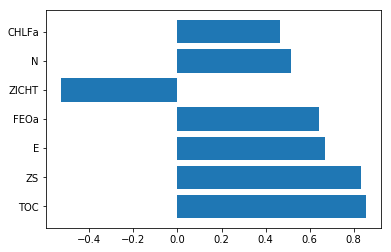

In [55]:
assert all(covall.par_i[k]==i for i,k in covall.i_par.items())

In [56]:
ca = covall_loc['DANTZGT']

n, sij,si,sj,si2,sj2 = ca.cov_sums[ca.par_i[('GELDHD', 'mS/m')]][ca.par_i[('POC', 'mg/l')]]
print(n, sij,si,sj,si2,sj2)

(sij/n - si*sj/(n*n))/math.sqrt((si2/n-(si/n)**2)*(sj2/n-(sj/n)**2))

4 516348.0 143470.0 14.200000000000001 5183277100.0 53.30000000000001


0.676444428795367